<a href="https://colab.research.google.com/github/abrarfayez/Machine-Learning/blob/main/Pattern_chestDiagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  !pip install kaggle

In [ ]:
 pip install split-folders


In [ ]:
  pip install split-folders tqdm


In [ ]:
# !pip install texttable
# !pip install pytorch_lightning

In [ ]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abrarfayez","key":"d57b7e21b1119e9f352097eadfbdc526"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 1.13G/1.14G [00:11<00:00, 159MB/s]
100% 1.14G/1.14G [00:11<00:00, 104MB/s]


In [ ]:
from zipfile import ZipFile
filename = 'covid19-radiography-database.zip'
with ZipFile(filename, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import numpy as np
import splitfolders 
import random
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from sklearn import metrics
from sklearn.metrics import  f1_score
import torch.utils.data as data
from torchvision import transforms as transforms
from torchvision import transforms, utils, datasets,models
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import pandas as pd
# from texttable import Texttable
# from pytorch_lightning import metrics

load the dataset from the directory


In [ ]:
PATH = '/content/COVID-19 Radiography Database'
CLASSES = ['COVID','NORMAL' ,'Viral Pneumonia']

split the paths of dataset into train,test and val:

In [ ]:
splitfolders.ratio(PATH, output="/content/output", seed=1337, ratio=(.6, .2,.2), group_prefix=None)

Copying files: 3886 files [00:22, 173.78 files/s]


**Data transformation:**

In [ ]:
TRANSFORM_IMG = transforms.Compose([ #resize the images to be all the same shape and convert it to tensors
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])
  

**Data Loaders**

In [ ]:
TRAIN_DATA_PATH='/content/output/train'
VAL_DATA_PATH='/content/output/val'
TEST_DATA_PATH='/content/output/test'

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)


val_data = torchvision.datasets.ImageFolder(root=VAL_DATA_PATH, transform=TRANSFORM_IMG)
val_loader = torch.utils.data.DataLoader(val_data, batch_size =16, shuffle=True)


test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_loader = torch.utils.data.DataLoader(test_data, batch_size =16, shuffle=False)



**Table of comparison**

In [ ]:
# table=Texttable()
# table.add_row(['Model type','Testing Accuracy','TESTING F1SCORE'])
# print(table.draw())

**FC Models:**

In [ ]:
class fc_few(nn.Module):
    
    def __init__(self):
        super(fc_few, self).__init__()
        self.l1 = nn.Linear(128*128*3,32)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(32, 3)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten the image --> [batches,x*w*h]
        x = self.l1(x)
        x = self.relu(x)
        x = self.l3(x)
        return F.log_softmax(x)

In [ ]:
class fc_many(nn.Module):
    
    def __init__(self):
        super(fc_many, self).__init__()
        self.l1 = nn.Linear(128*128*3,1024)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(1024, 512)
        self.l3 = nn.Linear(512, 240)
        self.l4 = nn.Linear(240, 120)
        self.l5 = nn.Linear(120, 64)
        self.l6 = nn.Linear(64, 32)
        self.dropout1= nn.Dropout(0.25)
        self.l7 = nn.Linear(32, 10)
        self.dropout2= nn.Dropout(0.5)
        self.l8 = nn.Linear(10, 3)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten the image --> [batches,x*w*h]
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)
        x = self.l4(x)
        x = self.relu(x)
        x = self.l5(x)
        x = self.relu(x)
        x = self.l6(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.l7(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.l8(x)
        return F.log_softmax(x)

**CNN Models:**

In [ ]:
class cnn2layers(nn.Module):
  def __init__(self):
        super(cnn2layers, self).__init__()
        self.conlayer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU())
        self.conlayer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.fc = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(64*64*64, 32),
            nn.ReLU(),
            nn.Linear(32,3))
  def forward(self, x):
        out = self.conlayer1(x)
        out = self.conlayer2(out)
        # out = out.view(out.size(0),-1)
        out = self.fc(out)
        return F.log_softmax(out)

In [ ]:
# use 6 conv layers to extract featur
class Cnn_few(nn.Module):
    def __init__(self):
        super(Cnn_few, self).__init__()
        self.conlayer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU())
        
        self.conlayer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        
        self.conlayer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        
        self.conlayer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))

        self.conlayer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        
        self.conlayer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))

        self.fc = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(256*16*16, 32),
            nn.ReLU(),
            nn.Linear(32,3))

            
        
    def forward(self, x):
        out = self.conlayer1(x)
        out = self.conlayer2(out)
        out = self.conlayer3(out)
        out = self.conlayer4(out)
        out = self.conlayer5(out)
        out = self.conlayer6(out)
        # out = out.view(out.size(0),-1)  # flatten
        out = self.fc(out)
        return F.log_softmax(out)

**CNN many**

In [ ]:
class Cnn_many(nn.Module):
  def __init__(self):
        super(Cnn_many, self).__init__()
        self.conlayer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.ReLU())
        
        self.conlayer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        
        self.conlayer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU())
        
        self.conlayer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))

        self.conlayer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU())
        
        self.conlayer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU())
        
        self.conlayer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        
        self.conlayer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU())
        
        self.conlayer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU())
        
        self.conlayer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))

        self.fc = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(512*8*8, 1024),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 3, bias=True))

            
        
  def forward(self, x):
        out = self.conlayer1(x)
        out = self.conlayer2(out)
        out = self.conlayer3(out)
        out = self.conlayer4(out)
        out = self.conlayer5(out)
        out = self.conlayer6(out)
        out = self.conlayer7(out)
        out = self.conlayer8(out)
        out = self.conlayer9(out)
        out = self.conlayer10(out)
        #print(out.shape)
        # out = out.view(out.size(0),-1)
        out = self.fc(out)
        return F.log_softmax(out)

In [ ]:
def F1_Score_Calcu(outputs, labels):
  op = outputs.cpu()
  la = labels.cpu()
  _, preds = torch.max(op, dim=1)
  return torch.tensor(f1_score(la,preds,average="weighted"))

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def plot_losses(params):
  #plot loss vs no of epochs after finishing all epochs
  train_losses = [param.get('train_loss') for param in params]
  val_loss = [param['val_loss'] for param in params]
  fig = plt.figure
  plt.xlabel('Epochs_No')
  plt.ylabel('Losses')

  plt.plot(train_losses, '-bx',val_loss, '-rx')

  plt.legend(['Training', 'Validation'])
 
  # plt.plot(train_losses,label=' Training loss vs epoch')
  plt.title('Losses vs. No. of epochs')
  plt.show()

In [ ]:
def plot_accu(params):
  train_acc = [param.get('train_accuracy') for param in params]
  val_acc = [param['val_acc'] for param in params]
  fig = plt.figure 
  plt.plot(val_acc,'-rx',train_acc, '-bx')
  plt.legend(['Validation','Training'])
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')
  plt.show()

In [ ]:
lr=30e-4 # learning rate
Epochs=12
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
grad_clip = 0.1
# device = torch.device("cuda")


**Evaluate the model **

In [ ]:
def evaluate(model, loader):
  model.eval()  # Change model to 'eval' mode (BN uses moving mean/var)
  out = {}
  val_loss = 0
  val_acc = []
  val_f1 = []
  crit= nn.CrossEntropyLoss()
  for images, labels in loader:
    # print('in eval')
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = crit(outputs,labels)
    val_loss+=loss.item()
    # _, predicted = torch.max(outputs.data, 1)
    # total += labels.size(0)
    # correct += (predicted == labels).sum()
    val_acc.append(accuracy(outputs, labels))
    val_f1.append(F1_Score_Calcu(outputs, labels)) 
  out['val_loss'] = val_loss/len(loader)
  out['val_acc'] = (torch.stack(val_acc).mean().item())*100
  out['val_f1_score'] = torch.stack(val_f1).mean().item()
  return out

In [ ]:
def print_eval(eval):
      print('Test loss: {:.6f}, Test Accuracy: {:.6f}, Test f1_score:{:.6f}'.format(
      eval['val_loss'],eval['val_acc'], eval['val_f1_score']))

**Train the model:**

In [ ]:
def training_loop(model, Epochs): # fn to train the models taking object model as a parameter
  
  params = []  
  train_losses = []
  train_accu = []
  f1_values = []
  criterion = nn.CrossEntropyLoss()
  torch.cuda.empty_cache()
  optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-4)
  # Set up one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,lr, epochs=Epochs, 
                                                steps_per_epoch=len(train_loader))
  

  for epoch in range(Epochs):
    for i,(images, labels) in enumerate(train_loader):
        # Forward + Backward + Optimize
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs,labels)
            train_losses.append(loss) # append loss
            loss.backward()
            f1_values.append(F1_Score_Calcu(outputs, labels)) # append f1 score 
            # _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum()
            train_accu.append(accuracy(outputs, labels))  # append train accuracy

            # if grad_clip: 
            #     nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
 
            optimizer.step()
            sched.step()

    #print the  total training loss , acc% and f1score after each epoch
    # print("Epoch [{}/{}], Training Loss: {:.4f}, Accuracy:{:.6f}, f1score: {:.4f}".format(
    #     epoch+1,Epochs,torch.stack(train_losses).mean().item(),(torch.stack(train_accu).mean().item())*100,  torch.stack(f1_values).mean().item()))
   #validate the model and print its accuracy
    eval = evaluate(model,val_loader)
    eval['train_loss'] = torch.stack(train_losses).mean().item()  # combine all losses and get mean
    eval['train_accuracy'] = (torch.stack(train_accu).mean().item())*100
    eval['train_f1'] = torch.stack(f1_values).mean().item()
    print("Epoch [{}/{}],Training Loss: {:.4f},Accuracy:{:.6f},f1score: {:.4f}".format(
        epoch+1,Epochs,eval['train_loss'],eval['train_accuracy'],eval['train_f1']))
    print_eval(eval)
    params.append(eval)
    print('\n')

  plot_losses(params)
  plot_accu(params)


Save the Trained Model

**Model 1:  FC 2 layers**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch [1/15],Training Loss: 0.5311,Accuracy:76.623929,f1score: 0.7453
Test loss: 0.345680, Test Accuracy: 87.051284, Test f1_score:0.868665


Epoch [2/15],Training Loss: 0.5679,Accuracy:77.927345,f1score: 0.7600
Test loss: 0.395441, Test Accuracy: 84.615386, Test f1_score:0.839846


Epoch [3/15],Training Loss: 0.5039,Accuracy:80.455840,f1score: 0.7896
Test loss: 0.265775, Test Accuracy: 90.256411, Test f1_score:0.901499


Epoch [4/15],Training Loss: 0.4623,Accuracy:82.232904,f1score: 0.8109
Test loss: 0.228398, Test Accuracy: 91.739929, Test f1_score:0.916221


Epoch [5/15],Training Loss: 0.4340,Accuracy:83.521360,f1score: 0.8256
Test loss: 0.945015, Test Accuracy: 68.479854, Test f1_score:0.627270


Epoch [6/15],Training Loss: 0.4216,Accuracy:84.002841,f1score: 0.8301
Test loss: 0.234829, Test Accuracy: 91.282046, Test f1_score:0.913355


Epoch [7/15],Training Loss: 0.3974,Accuracy:84.987789,f1score: 0.8410
Test loss: 0.225603, Test Accuracy: 91.538465, Test f1_score:0.913268


Epoch 

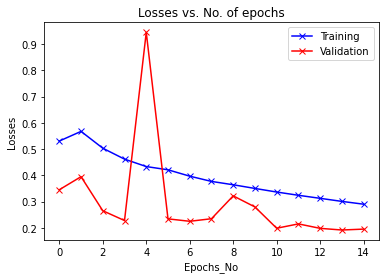

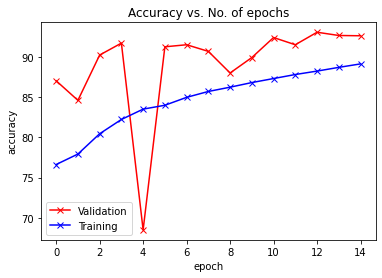

In [ ]:
FC_few = fc_few()
FC_few.to(device)
training_loop(FC_few, 15)

In [ ]:
print_eval(evaluate(FC_few, test_loader))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


Test loss: 0.226630, Test Accuracy: 92.019224, Test f1_score:0.955273


**Model 2:  FC --> 8 layers**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/15],Training Loss: 1.0141,Accuracy:36.495727,f1score: 0.2963
Test loss: 0.873853, Test Accuracy: 67.307693, Test f1_score:0.658086


Epoch [2/15],Training Loss: 0.8326,Accuracy:50.192308,f1score: 0.4375
Test loss: 0.775596, Test Accuracy: 54.523808, Test f1_score:0.460724


Epoch [3/15],Training Loss: 0.7799,Accuracy:53.760684,f1score: 0.4716
Test loss: 0.599223, Test Accuracy: 60.769230, Test f1_score:0.516689


Epoch [4/15],Training Loss: 0.7560,Accuracy:55.576926,f1score: 0.4881
Test loss: 0.770617, Test Accuracy: 56.501836, Test f1_score:0.476000


Epoch [5/15],Training Loss: 0.7422,Accuracy:56.341887,f1score: 0.4942
Test loss: 0.706037, Test Accuracy: 59.890109, Test f1_score:0.508134


Epoch [6/15],Training Loss: 0.7267,Accuracy:57.215101,f1score: 0.5019
Test loss: 0.589986, Test Accuracy: 67.216122, Test f1_score:0.617747


Epoch [7/15],Training Loss: 0.7194,Accuracy:57.808304,f1score: 0.5070
Test loss: 0.693469, Test Accuracy: 58.260071, Test f1_score:0.590022


Epoch 

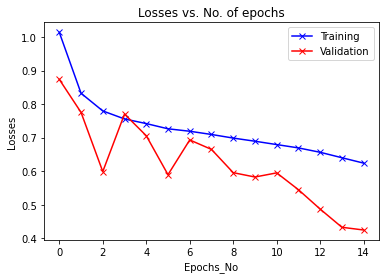

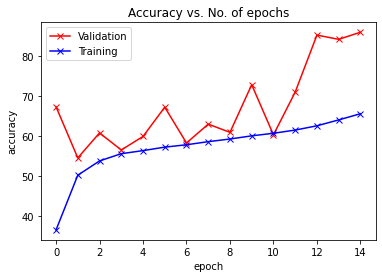

In [ ]:
FC_many = fc_many()
FC_many.to(device)
training_loop(FC_many,15)

In [ ]:
print_eval(evaluate(FC_many, test_loader))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test loss: 0.428631, Test Accuracy: 84.262830, Test f1_score:0.901374


**Model 3:  CNN --> 4 layers**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/12],Training Loss: 0.4064,Accuracy:84.059834,f1score: 0.8272
Test loss: 0.466333, Test Accuracy: 80.604386, Test f1_score:0.791089


Epoch [2/12],Training Loss: 0.3522,Accuracy:86.346155,f1score: 0.8555
Test loss: 0.838618, Test Accuracy: 68.681318, Test f1_score:0.630089


Epoch [3/12],Training Loss: 0.3298,Accuracy:87.535614,f1score: 0.8683
Test loss: 0.192836, Test Accuracy: 93.076932, Test f1_score:0.928798


Epoch [4/12],Training Loss: 0.3144,Accuracy:88.322639,f1score: 0.8779
Test loss: 0.262129, Test Accuracy: 91.282046, Test f1_score:0.912096


Epoch [5/12],Training Loss: 0.2892,Accuracy:89.367527,f1score: 0.8893
Test loss: 1.173421, Test Accuracy: 64.578754, Test f1_score:0.601816


Epoch [6/12],Training Loss: 0.2618,Accuracy:90.405977,f1score: 0.9005
Test loss: 0.204894, Test Accuracy: 93.150181, Test f1_score:0.931057


Epoch [7/12],Training Loss: 0.2328,Accuracy:91.471303,f1score: 0.9116
Test loss: 0.208352, Test Accuracy: 93.278396, Test f1_score:0.933901


Epoch 

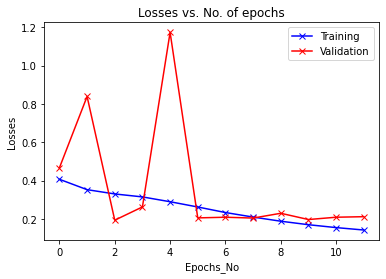

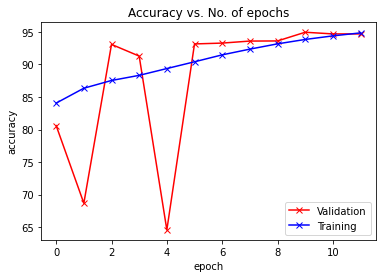

In [ ]:
cnn2 = cnn2layers()
cnn2.to(device)
training_loop(cnn2,12)

In [ ]:
print_eval(evaluate(cnn2, test_loader))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test loss: 0.281676, Test Accuracy: 93.397433, Test f1_score:0.963509


**Model 4:  CNN --> 8 layers**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/15],Training Loss: 0.6673,Accuracy:67.393160,f1score: 0.6295
Test loss: 0.436159, Test Accuracy: 89.871794, Test f1_score:0.896447


Epoch [2/15],Training Loss: 0.5190,Accuracy:77.222222,f1score: 0.7503
Test loss: 0.389332, Test Accuracy: 87.252748, Test f1_score:0.872331


Epoch [3/15],Training Loss: 0.4735,Accuracy:79.957253,f1score: 0.7832
Test loss: 0.280324, Test Accuracy: 90.512830, Test f1_score:0.904980


Epoch [4/15],Training Loss: 0.4538,Accuracy:81.442314,f1score: 0.8005
Test loss: 0.484892, Test Accuracy: 77.728933, Test f1_score:0.762317


Epoch [5/15],Training Loss: 0.4279,Accuracy:82.888889,f1score: 0.8166
Test loss: 0.242639, Test Accuracy: 91.684985, Test f1_score:0.918326


Epoch [6/15],Training Loss: 0.3952,Accuracy:84.458685,f1score: 0.8344
Test loss: 0.235415, Test Accuracy: 91.282058, Test f1_score:0.914828


Epoch [7/15],Training Loss: 0.3675,Accuracy:85.702074,f1score: 0.8483
Test loss: 0.251612, Test Accuracy: 91.813189, Test f1_score:0.918602


Epoch 

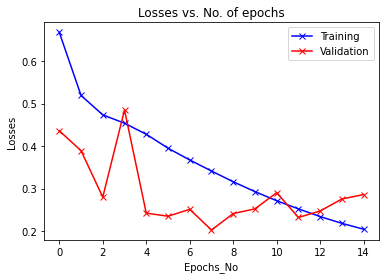

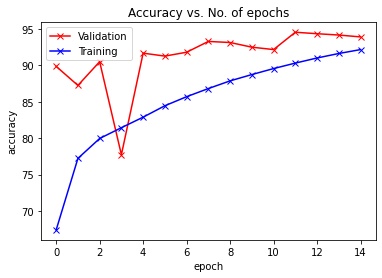

In [ ]:
# torch.cuda.empty_cache()
cnn_few  = Cnn_few()
cnn_few.to(device)
training_loop(cnn_few,15)

In [ ]:
print_eval(evaluate(cnn_few, test_loader))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test loss: 0.334319, Test Accuracy: 93.942302, Test f1_score:0.966823


**Model 5 : CNN --> 13 layers **

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/12],Training Loss: 1.0112,Accuracy:60.384619,f1score: 0.5972
Test loss: 0.611221, Test Accuracy: 63.736260, Test f1_score:0.565871


Epoch [2/12],Training Loss: 0.9887,Accuracy:57.008553,f1score: 0.5289
Test loss: 0.817704, Test Accuracy: 67.289382, Test f1_score:0.660539


Epoch [3/12],Training Loss: 1.0051,Accuracy:51.324791,f1score: 0.4441
Test loss: 1.097438, Test Accuracy: 34.523812, Test f1_score:0.191834


Epoch [4/12],Training Loss: 1.0284,Accuracy:47.115386,f1score: 0.3822
Test loss: 1.097854, Test Accuracy: 34.468862, Test f1_score:0.199983


Epoch [5/12],Training Loss: 1.0422,Accuracy:44.709399,f1score: 0.3462
Test loss: 1.097357, Test Accuracy: 34.706959, Test f1_score:0.200755


Epoch [6/12],Training Loss: 1.0516,Accuracy:43.005696,f1score: 0.3212
Test loss: 1.097334, Test Accuracy: 34.542125, Test f1_score:0.193986


Epoch [7/12],Training Loss: 1.0582,Accuracy:41.709402,f1score: 0.3026
Test loss: 1.097229, Test Accuracy: 34.706962, Test f1_score:0.194685


Epoch 

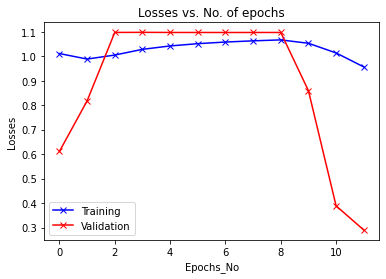

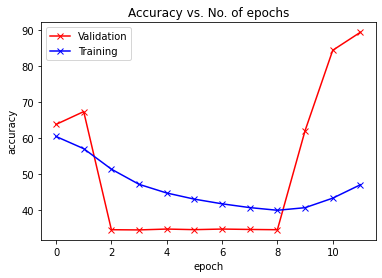

In [ ]:
cnn_many = Cnn_many()
cnn_many.to(device)
training_loop(cnn_many,15)

In [ ]:
print_eval(evaluate(cnn_many, test_loader))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test loss: 0.326581, Test Accuracy: 89.006412, Test f1_score:0.935830


**Model 6: Resnet 18**

Epoch [1/15],Training Loss: 0.3291,Accuracy:88.227737,f1score: 0.8842
Test loss: 0.361734, Test Accuracy: 85.615081, Test f1_score:0.853316


Epoch [2/15],Training Loss: 0.5627,Accuracy:76.402938,f1score: 0.7401
Test loss: 0.602078, Test Accuracy: 72.052157, Test f1_score:0.698502


Epoch [3/15],Training Loss: 0.5564,Accuracy:76.436025,f1score: 0.7452
Test loss: 0.622285, Test Accuracy: 78.854877, Test f1_score:0.773336


Epoch [4/15],Training Loss: 0.5610,Accuracy:76.849508,f1score: 0.7503
Test loss: 0.773578, Test Accuracy: 58.021539, Test f1_score:0.523640


Epoch [5/15],Training Loss: 0.5638,Accuracy:77.181661,f1score: 0.7549
Test loss: 0.354381, Test Accuracy: 88.520408, Test f1_score:0.884718


Epoch [6/15],Training Loss: 0.5287,Accuracy:78.830689,f1score: 0.7737
Test loss: 0.319004, Test Accuracy: 88.166100, Test f1_score:0.879533


Epoch [7/15],Training Loss: 0.4903,Accuracy:80.421072,f1score: 0.7915
Test loss: 0.199691, Test Accuracy: 92.757940, Test f1_score:0.926083


Epoch 

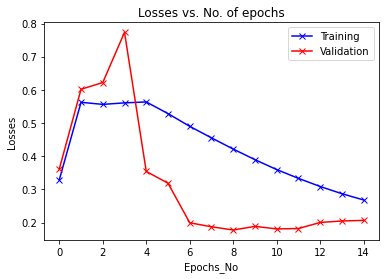

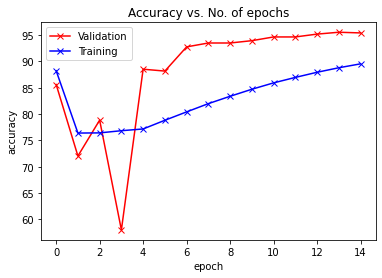

In [ ]:
res_1 = models.resnet18(pretrained=False)
res_1.to(device)
# print(next(model.parameters()).is_cuda)
num_ftrs = res_1.fc.in_features
res_1.fc = nn.Linear(num_ftrs, 3).to(device)
training_loop(res_1,15)

In [ ]:
print_eval(evaluate(res_1, test_loader))

Test loss: 0.271720, Test Accuracy: 94.897962, Test f1_score:0.972893


**Model 7: Resnet 18 pretrained**

Epoch [1/10],Training Loss: 0.2175,Accuracy:92.403483,f1score: 0.9254
Test loss: 0.221110, Test Accuracy: 94.387758, Test f1_score:0.943424


Epoch [2/10],Training Loss: 0.6868,Accuracy:63.182986,f1score: 0.5568
Test loss: 1.100743, Test Accuracy: 34.509635, Test f1_score:0.186627


Epoch [3/10],Training Loss: 85.2102,Accuracy:54.042137,f1score: 0.4392
Test loss: 3.327987, Test Accuracy: 34.708050, Test f1_score:0.190664


Epoch [4/10],Training Loss: 67.9659,Accuracy:49.102005,f1score: 0.3777
Test loss: 1.098902, Test Accuracy: 34.410429, Test f1_score:0.192975


Epoch [5/10],Training Loss: 54.5924,Accuracy:46.206415,f1score: 0.3398
Test loss: 1.097641, Test Accuracy: 34.708050, Test f1_score:0.189839


Epoch [6/10],Training Loss: 45.6766,Accuracy:44.269538,f1score: 0.3148
Test loss: 1.097352, Test Accuracy: 34.608841, Test f1_score:0.186701


Epoch [7/10],Training Loss: 39.3081,Accuracy:42.894393,f1score: 0.2970
Test loss: 1.097292, Test Accuracy: 34.509635, Test f1_score:0.186088


E

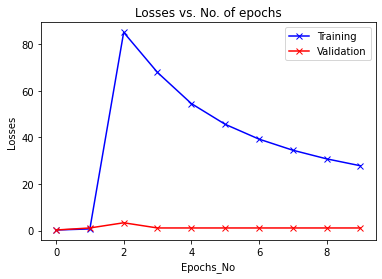

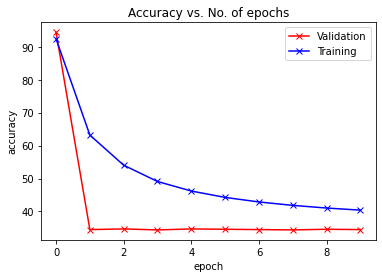

In [ ]:
Res_18 = models.resnet18(pretrained=True)
Res_18.to(device)
num_ftrs = Res_18.fc.in_features
Res_18.fc = nn.Dropout(0.25)
Res_18.fc = nn.Linear(num_ftrs, 3).to(device)
# for param in Res_18.parameters():
#  param.require_grad = False
# for param in Res_18.fc.parameters():
#   param.require_grad = True
# # torch.nn.functional.softmax(Res_18.fc, dim=0)

training_loop(Res_18,10)

In [ ]:
print_eval(evaluate(Res_18, test_loader))

Test loss: 1.096904, Test Accuracy: 35.076532, Test f1_score:0.348147


In [ ]:
# path = 'res18.pt'
# torch.save(Res_18.state_dict(), path) # save the model 

In [ ]:
# Res_18.load_state_dict(torch.load(path)) # load the model

In [ ]:
# # freeze all parameters
# for param in Res_18.parameters():
#  param.require_grad = False

# training_loop(Res_18, True)

In [ ]:
# print_eval(evaluate(Res_18, test_loader))

**Model 8: Resnet 50**

Epoch [1/15],Training Loss: 0.6189,Accuracy:74.786329,f1score: 0.7491
Test loss: 0.511959, Test Accuracy: 81.300366, Test f1_score:0.813882


Epoch [2/15],Training Loss: 0.8019,Accuracy:66.047013,f1score: 0.6202
Test loss: 0.911179, Test Accuracy: 63.021982, Test f1_score:0.549456


Epoch [3/15],Training Loss: 0.7606,Accuracy:67.792028,f1score: 0.6394
Test loss: 0.927416, Test Accuracy: 61.813194, Test f1_score:0.582392


Epoch [4/15],Training Loss: 0.7125,Accuracy:70.160258,f1score: 0.6676
Test loss: 0.463783, Test Accuracy: 82.637358, Test f1_score:0.825454


Epoch [5/15],Training Loss: 0.6694,Accuracy:72.290599,f1score: 0.6942
Test loss: 0.841005, Test Accuracy: 65.604401, Test f1_score:0.587255


Epoch [6/15],Training Loss: 0.6313,Accuracy:74.002850,f1score: 0.7154
Test loss: 0.470328, Test Accuracy: 83.717954, Test f1_score:0.837779


Epoch [7/15],Training Loss: 0.5919,Accuracy:75.763136,f1score: 0.7360
Test loss: 0.342640, Test Accuracy: 88.736266, Test f1_score:0.885620


Epoch 

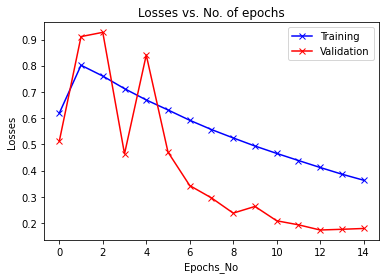

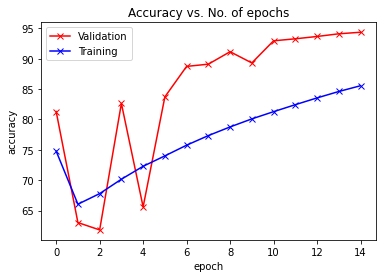

In [ ]:
res_2 = models.resnet50(pretrained=False)
res_2.to(device)
# print(next(model.parameters()).is_cuda)
num_ftrs = res_2.fc.in_features
res_2.fc = nn.Linear(num_ftrs, 3).to(device)
training_loop(res_2, 15)

In [ ]:
print_eval(evaluate(res_2, test_loader))

Test loss: 0.186092, Test Accuracy: 93.814105, Test f1_score:0.966589


**Model 9: Resnet 50 pretrained**

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Epoch [1/15],Training Loss: 0.2532,Accuracy:91.352737,f1score: 0.9147
Test loss: 0.150010, Test Accuracy: 94.515306, Test f1_score:0.944370


Epoch [2/15],Training Loss: 0.5161,Accuracy:77.432281,f1score: 0.7367
Test loss: 0.643091, Test Accuracy: 63.222790, Test f1_score:0.524966


Epoch [3/15],Training Loss: 0.5616,Accuracy:73.784506,f1score: 0.6923
Test loss: 0.599032, Test Accuracy: 74.773246, Test f1_score:0.740376


Epoch [4/15],Training Loss: 2127979.5000,Accuracy:70.074135,f1score: 0.6461
Test loss: 101714.529815, Test Accuracy: 34.608841, Test f1_score:0.187938


Epoch [5/15],Training Loss: 414393008128.0000,Accuracy:62.996578,f1score: 0.5552
Test loss: 1.102732, Test Accuracy: 34.382084, Test f1_score:0.190458


Epoch [6/15],Training Loss: 345327501312.0000,Accuracy:58.246422,f1score: 0.4940
Test loss: 1.098851, Test Accuracy: 34.382084, Test f1_score:0.188427


Epoch [7/15],Training Loss: 295995015168.0000,Accuracy:54.850668,f1score: 0.4502
Test loss: 1.097613, Test Accurac

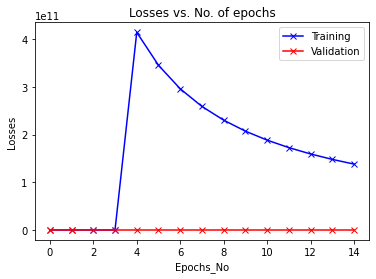

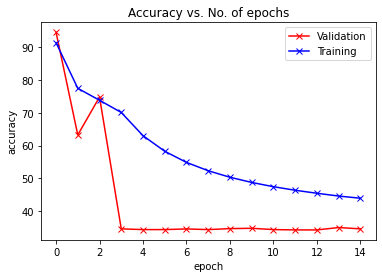

In [ ]:
Res_50 = models.resnet50(pretrained=True)
Res_50.to(device)
num_ftrs = Res_50.fc.in_features
Res_50.fc = nn.Linear(num_ftrs, 3).to(device)
training_loop(Res_50, 15)

In [ ]:
print_eval(evaluate(Res_50, test_loader))

Test loss: 1.096933, Test Accuracy: 35.076532, Test f1_score:0.348147


In [ ]:
path = 'res50.pt'
torch.save(Res_50.state_dict(), path)

**Model 10: Dense net:**

Epoch [1/15],Training Loss: 0.3638,Accuracy:86.624378,f1score: 0.8679
Test loss: 1.292715, Test Accuracy: 73.072565, Test f1_score:0.717612


Epoch [2/15],Training Loss: 0.5789,Accuracy:74.620563,f1score: 0.7188
Test loss: 0.585171, Test Accuracy: 64.909297, Test f1_score:0.579728


Epoch [3/15],Training Loss: 0.5664,Accuracy:74.805421,f1score: 0.7208
Test loss: 0.341298, Test Accuracy: 87.585026, Test f1_score:0.875097


Epoch [4/15],Training Loss: 0.5415,Accuracy:76.578063,f1score: 0.7430
Test loss: 0.463939, Test Accuracy: 82.142860, Test f1_score:0.817743


Epoch [5/15],Training Loss: 0.5169,Accuracy:78.103203,f1score: 0.7618
Test loss: 0.364134, Test Accuracy: 88.676304, Test f1_score:0.885068


Epoch [6/15],Training Loss: 0.4791,Accuracy:80.022830,f1score: 0.7840
Test loss: 0.243760, Test Accuracy: 90.107709, Test f1_score:0.901823


Epoch [7/15],Training Loss: 0.4473,Accuracy:81.614143,f1score: 0.8021
Test loss: 0.205633, Test Accuracy: 91.992629, Test f1_score:0.920953


Epoch 

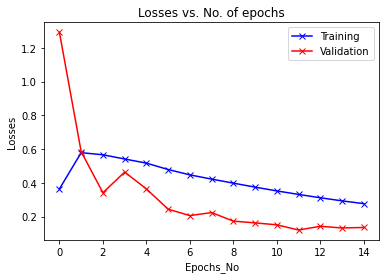

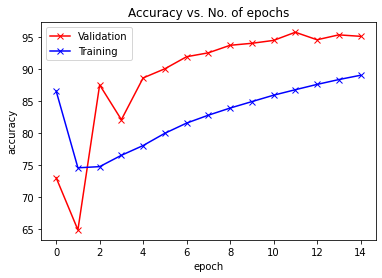

In [ ]:
densenet_1 = models.densenet161(pretrained=False)
densenet_1.to(device)
num_ftrs = densenet_1.classifier.in_features
densenet_1.classifier= nn.Sequential(
   nn.Linear(num_ftrs, 3).to(device))
training_loop(densenet_1,15)

In [ ]:
print_eval(evaluate(densenet_1, test_loader))

Test loss: 0.193594, Test Accuracy: 93.418372, Test f1_score:0.964069


**Model 11: Dense net pretrained**

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth



Epoch [1/15],Training Loss: 0.2187,Accuracy:92.959994,f1score: 0.9322
Test loss: 0.139303, Test Accuracy: 95.918369, Test f1_score:0.958767


Epoch [2/15],Training Loss: 0.5224,Accuracy:76.523584,f1score: 0.7321
Test loss: 0.627722, Test Accuracy: 65.901357, Test f1_score:0.580874


Epoch [3/15],Training Loss: 0.5410,Accuracy:75.809467,f1score: 0.7265
Test loss: 0.802727, Test Accuracy: 69.671202, Test f1_score:0.630294


Epoch [4/15],Training Loss: 575547161219956736.0000,Accuracy:67.123288,f1score: 0.6138
Test loss: 107712710582789600.000000, Test Accuracy: 30.810657, Test f1_score:0.158412


Epoch [5/15],Training Loss: 71664241554067816448.0000,Accuracy:60.041255,f1score: 0.5239
Test loss: 13208122089999466496.000000, Test Accuracy: 34.708050, Test f1_score:0.188913


Epoch [6/15],Training Loss: 59761192554555506688.0000,Accuracy:55.426264,f1score: 0.4660
Test loss: 3424282476544.000000, Test Accuracy: 34.608841, Test f1_score:0.191609


Epoch [7/15],Training Loss: 5122388058906086

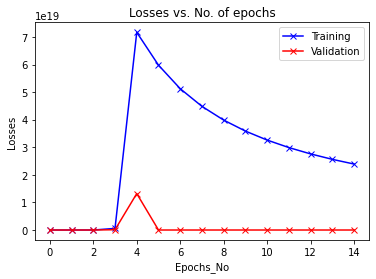

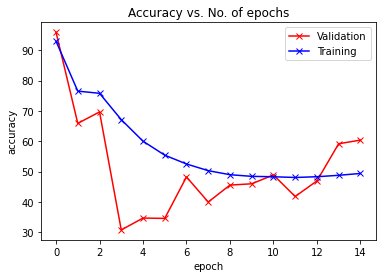

In [ ]:
densenet = models.densenet161(pretrained=True)
densenet.to(device)
num_ftrs = densenet.classifier.in_features
densenet.classifier= nn.Sequential(
   nn.Linear(num_ftrs, 3).to(device))
training_loop(densenet,15)

In [ ]:
print_eval(evaluate(densenet, test_loader))

Test loss: 3298101080.816327, Test Accuracy: 57.678574, Test f1_score:0.717837


**Model 12: Inception v3:**

/usr/local/lib/python3.6/dist-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


Epoch [1/15],Training Loss: 0.6819,Accuracy:69.267589,f1score: 0.6961
Test loss: 0.887269, Test Accuracy: 71.414405, Test f1_score:0.693188


Epoch [2/15],Training Loss: 0.7416,Accuracy:68.283004,f1score: 0.6643
Test loss: 0.441080, Test Accuracy: 83.545917, Test f1_score:0.828337


Epoch [3/15],Training Loss: 0.6917,Accuracy:71.130401,f1score: 0.6896
Test loss: 0.667060, Test Accuracy: 61.337870, Test f1_score:0.517125


Epoch [4/15],Training Loss: 0.6575,Accuracy:73.013306,f1score: 0.7081
Test loss: 0.494648, Test Accuracy: 84.084469, Test f1_score:0.839870


Epoch [5/15],Training Loss: 0.6490,Accuracy:73.283005,f1score: 0.7076
Test loss: 0.483483, Test Accuracy: 81.689346, Test f1_score:0.809608


Epoch [6/15],Training Loss: 0.6208,Accuracy:74.767804,f1score: 0.7247
Test loss: 0.283360, Test Accuracy: 90.433675, Test f1_score:0.904420


Epoch [7/15],Training Loss: 0.5807,Accuracy:76.660621,f1score: 0.7465
Test loss: 0.332111, Test Accuracy: 88.038552, Test f1_score:0.876538


Epoch 

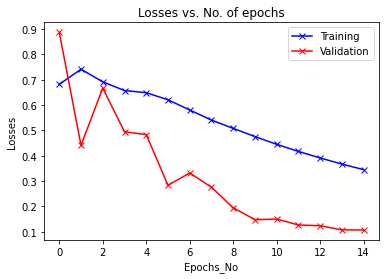

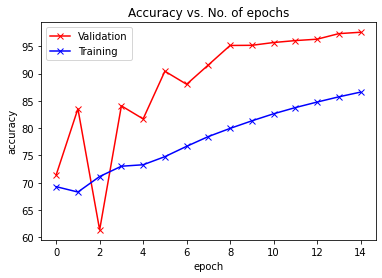

In [ ]:
incp_v3_1 = models.inception_v3(pretrained=False,aux_logits=False)
incp_v3_1.to(device)
num_ftrs = incp_v3_1.fc.in_features
incp_v3_1.fc = nn.Linear(num_ftrs, 3).to(device)
training_loop(incp_v3_1,15)

In [ ]:
print_eval(evaluate(incp_v3_1, test_loader))

Test loss: 0.158012, Test Accuracy: 94.387758, Test f1_score:0.968560


**Model 13: Inception v3 pretrained:**

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



Epoch [1/15],Training Loss: 0.3919,Accuracy:85.853827,f1score: 0.8591
Test loss: 0.248677, Test Accuracy: 91.581631, Test f1_score:0.916266


Epoch [2/15],Training Loss: 0.7685,Accuracy:61.437583,f1score: 0.5403
Test loss: 1.097787, Test Accuracy: 34.481290, Test f1_score:0.189402


Epoch [3/15],Training Loss: 0.8792,Accuracy:52.578872,f1score: 0.4244
Test loss: 1.097205, Test Accuracy: 34.608841, Test f1_score:0.189158


Epoch [4/15],Training Loss: 0.9340,Accuracy:47.827482,f1score: 0.3637
Test loss: 1.099540, Test Accuracy: 34.608841, Test f1_score:0.189378


Epoch [5/15],Training Loss: 299784224.0000,Accuracy:45.341688,f1score: 0.3301
Test loss: 412819646.857143, Test Accuracy: 34.708050, Test f1_score:0.193971


Epoch [6/15],Training Loss: 334288781312.0000,Accuracy:43.402991,f1score: 0.3056
Test loss: 223126.438776, Test Accuracy: 34.282878, Test f1_score:0.183177


Epoch [7/15],Training Loss: 286533287936.0000,Accuracy:41.690761,f1score: 0.2851
Test loss: 8274.615354, Test Accur

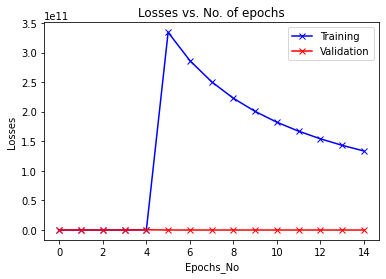

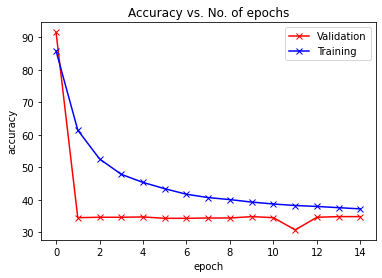

In [ ]:
incp_v3 = models.inception_v3(pretrained=True,aux_logits=False)
incp_v3.to(device)
num_ftrs = incp_v3.fc.in_features
incp_v3.fc = nn.Linear(num_ftrs, 3).to(device)
training_loop(incp_v3,15)

In [ ]:
print_eval(evaluate(incp_v3, test_loader))

Test loss: 1.257785, Test Accuracy: 35.076532, Test f1_score:0.348147
